# Case_study_4_1

Gradient descedent vs. Stochastic gradient descent vs Newton method

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_regression
from local.lib.utils import solver_cvx, grad_FOM, grad_SOM, grad_inst, eval_loss, plot_surface
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

[1.6506009  0.92312798] [1.65047959 0.92296556]


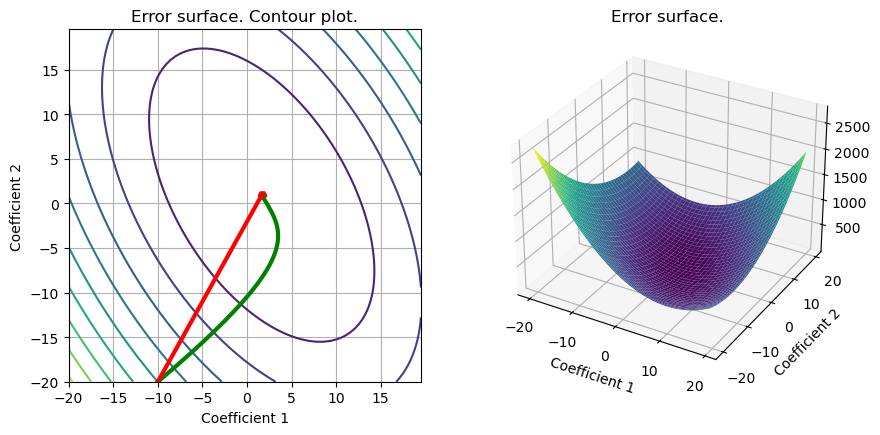

In [2]:
# Loading scenarios
# ===========================
scenario=1;
data_reg, set_up=scenarios_regression(scenario);

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.pnorm(X @ w - Y, p=2)**2
reg_L2 = lambda w: cp.pnorm(w, p=2)**2

loss_LS_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)
grad_LS_L2 = lambda n, X, Y, w, lambd: (2/n)*X.T@(X @ w - Y) + lambd * w
Hess_LS_L2 = lambda n, X, Y, w, lambd: (2/n)*X.T@X + lambd * np.eye(X.shape[1])
grad_LS_L2_inst = lambda n, X, Y, w, lambd: 2*X.T@(X @ w - Y) + lambd * w

# Different ways to solve theoreticaly the LS
#=========================================
# Solution of the empirical risk using CVX
w_L2_cvx=solver_cvx(set_up,loss_LS_L2);
Xtrain = set_up['Xtrain'][:,:set_up['d']+1]
w_opt=np.linalg.inv(2/set_up['Niter_train']*Xtrain.T@Xtrain + set_up['Lambda']*np.eye(set_up['d']+1))@((2/set_up['Niter_train'])*Xtrain.T)@set_up['ytrain'][:,0];
print(w_L2_cvx, w_opt)


w = cp.Variable(w_L2_cvx.shape[0])
w.value = w_L2_cvx
loss_opt=loss_LS_L2(set_up['Niter_train'],set_up['Xtrain'][:,0:set_up['d']+1],set_up['ytrain'][:,0],w_L2_cvx,set_up['Lambda']).value

# Gradient descent
out_gd = grad_FOM(set_up,grad_LS_L2)
loss_grad=eval_loss(out_gd,set_up,loss_LS_L2)

# Newton algorithm
out_hess =grad_SOM(set_up,grad_LS_L2,Hess_LS_L2)                    

S =plot_surface(set_up,loss_LS_L2,w_L2_cvx,include_grad=True,grad=np.array([out_gd,out_hess]),color=['green','red']);
loss_hess=eval_loss(out_hess,set_up,loss_LS_L2)

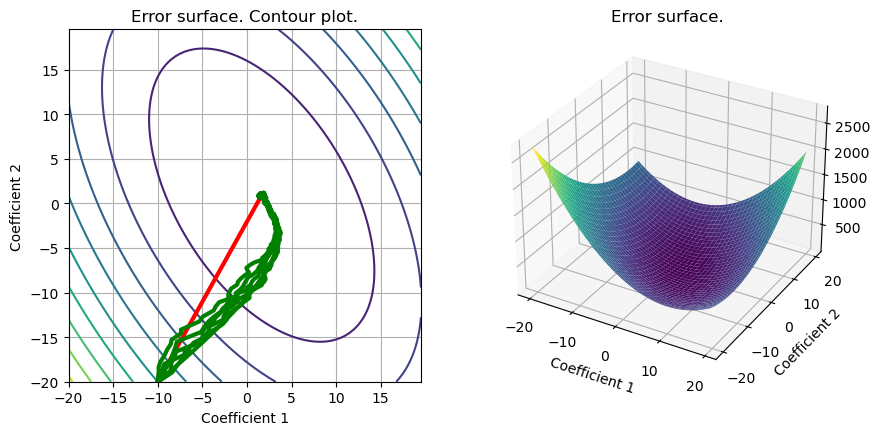

In [3]:
# Stochastic gradient descent (several realizations). Comparison with GD and Newton.
loss_inst=np.zeros((set_up['Number_tests'],set_up['Niter_train']))
out_inst_g = np.zeros((set_up['Number_tests']+2,set_up['d']+1,set_up['Niter_train']))
out_inst_g[0,:] = out_hess
out_inst_g[1,:] = out_gd
for kk in range(2,set_up['Number_tests']+2):
    out_inst=grad_inst(set_up,grad_LS_L2_inst,kk-2);
    out_inst_g[kk,:] = out_inst
    loss_inst[kk-2,:]=eval_loss(out_inst,set_up,loss_LS_L2);

S = plot_surface(set_up,loss_LS_L2,w_L2_cvx,include_grad=True,grad=out_inst_g,color = ['red']+['green']*(set_up['Number_tests'] + 1));    

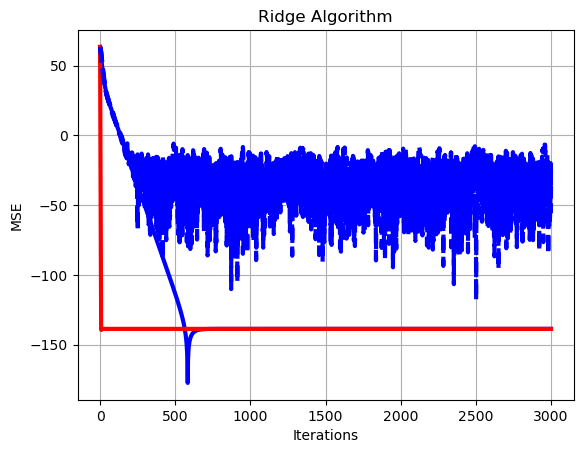

In [4]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_grad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_hess-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3)
for k in range(set_up['Number_tests']):
    plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_inst[k,:]-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),linestyle='dashed',color='b', linewidth = 3),
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.title('Ridge Algorithm')
plt.show()